In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
age_gender=pd.read_csv('age_gender_info.csv',index_col=0)

#데이터 확인

In [ ]:
print("train shape: {}, test shape: {}, submission shape: {}, age_gender_info shape: {}".format(train.shape,test.shape, submission.shape, age_gender.shape))

train shape: (2952, 15), test shape: (1022, 14), submission shape: (150, 2), age_gender_info shape: (16, 22)


##train & test

In [ ]:
train.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [ ]:
test.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0


###header 간소화

도보 10분거리 내 지하철역 수(환승노선 수 반영) --> 지하철 <br>
도보 10분거리 내 버스정류장 수 -> 버스

In [ ]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수'],
      dtype='object')

In [ ]:
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스', '단지내주차면수', '등록차량수']

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스','단지내주차면수']

### categorical 값의 unique 값 확인

In [ ]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철', '버스', '단지내주차면수', '등록차량수'],
      dtype='object')

In [ ]:
train_cols=['임대건물구분', '지역', '공급유형', '자격유형', '지하철','버스']

for col in train_cols:
    print("{} 의 unique 값 ::: {}".format(col,pd.unique(train[col])))

임대건물구분 의 unique 값 ::: ['아파트' '상가']
지역 의 unique 값 ::: ['경상북도' '경상남도' '대전광역시' '경기도' '전라북도' '강원도' '광주광역시' '충청남도' '부산광역시' '제주특별자치도'
 '울산광역시' '충청북도' '전라남도' '대구광역시' '서울특별시' '세종특별자치시']
공급유형 의 unique 값 ::: ['국민임대' '공공임대(50년)' '영구임대' '임대상가' '공공임대(10년)' '공공임대(분납)' '장기전세' '공공분양'
 '행복주택' '공공임대(5년)']
자격유형 의 unique 값 ::: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O']
지하철 의 unique 값 ::: [ 0.  1. nan  2.  3.]
버스 의 unique 값 ::: [ 3.  1.  2.  6. 10.  5.  4.  7. 12. 14.  8.  0. 20. 11. 16. 15. nan 19.]


###결측치 확인

In [ ]:
train.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       569
임대료         569
지하철         211
버스            4
단지내주차면수       0
등록차량수         0
dtype: int64

In [ ]:
test.isnull().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          2
임대보증금       180
임대료         180
지하철          42
버스            0
단지내주차면수       0
dtype: int64

임대보증금, 임대료, 지하철, 버스, 자격유형 -> 결측치 채우기

## submission

In [ ]:
submission.head(3)

,code,num
0,C1072,0
1,C1128,0
2,C1456,0


submission과 test의 행의 갯수가 위에서 shape로 확인했다시피 다르다

In [ ]:
print("test에서 단지코드의 갯수 : ",len(test['단지코드'].unique()))
print("submission에서 단지코드의 갯수 : ",len(submission['code'].unique()))

test에서 단지코드의 갯수 :  150
submission에서 단지코드의 갯수 :  150


test는 단지의 여러 세대의 정보가 있으므로 결국 단지코드별로 정리해서 학습&예측 을 해야한다

#전처리

## 결측치 채우기

### 버스

test에는 결측치가 없다

In [ ]:
train['버스']=train['버스'].fillna(-1)

### 지하철

In [ ]:
print('지하철 결측치 단지 지역: ', train.loc[train['지하철'].isnull()]['지역'].unique())
print('지하철 결측치 단지 지역: ', test.loc[test['지하철'].isnull()]['지역'].unique())

지하철 결측치 단지 지역:  ['충청남도' '대전광역시' '경상남도']
지하철 결측치 단지 지역:  ['충청남도' '대전광역시']


결측치가 있는 지역이 몇 개 없어서 각각을 또 하나의 카테고리들로 각각 대입해서 넣기로 했다

*   충청남도 -> -1
*   대전광역시 -> -2
*   경상남도 -> -3



In [ ]:
train['지하철'][(train['지하철'].isnull())&(train['지역']=='충청남도')] =-1
train['지하철'][(train['지하철'].isnull())&(train['지역']=='대전광역시')] = -2
train['지하철'][(train['지하철'].isnull())&(train['지역']=='경상남도')] = -3

test['지하철'][(test['지하철'].isnull())&(test['지역']=='충청남도')] = -1
test['지하철'][(test['지하철'].isnull())&(test['지역']=='대전광역시')] = -2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

###자격유형

train에는 결측치가 없고 test에만 2개 있다

In [ ]:
test[test.자격유형.isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


#### 196번 행

In [ ]:
test.loc[test.단지코드 == 'C2411', '자격유형'].unique().tolist()

['A', nan]

In [ ]:
test[test.단지코드 == 'C2411']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0.0,2.0,840.0


단지 C2411은 결측치를 제외하고 모두 A로 이루어져 있다
->결측치를 A로 채운다

In [ ]:
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'

####258번 행

In [ ]:
test.loc[test.단지코드 == 'C2253', '자격유형'].unique().tolist()

[nan, 'C', 'D']

In [ ]:
test[test.단지코드 == 'C2253']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0.0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0.0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0.0,2.0,173.0
263,C2253,1161,상가,강원도,임대상가,22.91,1,0.0,D,NaN,NaN,0.0,2.0,173.0
264,C2253,1161,상가,강원도,임대상가,23.79,1,0.0,D,NaN,NaN,0.0,2.0,173.0
265,C2253,1161,상가,강원도,임대상가,23.79,1,0.0,D,NaN,NaN,0.0,2.0,173.0
266,C2253,1161,상가,강원도,임대상가,23.86,1,0.0,D,NaN,NaN,0.0,2.0,173.0
267,C2253,1161,상가,강원도,임대상가,23.86,1,0.0,D,NaN,NaN,0.0,2.0,173.0


공급유형이 영구임대 && 임대료 가 없으면 C 유형이기에 
자격유형이 nan인 행을 C로 채워준다

In [ ]:
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

In [ ]:
# print(train['자격유형'].unique())
# print(test['자격유형'].unique())

In [ ]:
# 자격유형을 단순히 숫자로 매핑하고 nan값은 -1로 입력하는 방법
# qualification_type_map={'A':0, 'B':1, 'C':2 ,'D':3 ,'E':4, 'F':5 ,'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11, 'M':12, 'N':13, 'O':14, np.nan:-1}
# train['자격유형']=train['자격유형'].map(qualification_type_map)
# test['자격유형']=test['자격유형'].map(qualification_type_map)

###임대보증금, 임대료

임대보증금과 임대료는 둘이 동시에 (함께) 항상 없다<br>
그래서 둘 다 0 으로 채운다

In [ ]:
train['임대보증금']=train['임대보증금'].fillna(0)
train['임대료']=train['임대료'].fillna(0)

test['임대보증금']=test['임대보증금'].fillna(0)
test['임대료']=test['임대료'].fillna(0)

학습시 '-'라는 값 때문에 에러가 나서 어느 열에 있는지 확인해보도록 한다

In [ ]:
for col in train.columns:
    print(col+"----------------")
    # train[train[col].str.contains('-')] 
    idx = train[train[col] == '-'].index
    print(idx)

단지코드----------------
Int64Index([], dtype='int64')
총세대수----------------
Int64Index([], dtype='int64')
임대건물구분----------------
Int64Index([], dtype='int64')
지역----------------
Int64Index([], dtype='int64')
공급유형----------------
Int64Index([], dtype='int64')
전용면적----------------
Int64Index([], dtype='int64')
전용면적별세대수----------------
Int64Index([], dtype='int64')
공가수----------------
Int64Index([], dtype='int64')
자격유형----------------
Int64Index([], dtype='int64')
임대보증금----------------
Int64Index([2547, 2548, 2549, 2550, 2551, 2680, 2681, 2682, 2683, 2906, 2907,
            2908],
           dtype='int64')
임대료----------------
Int64Index([2043, 2044, 2045, 2046, 2047, 2048, 2100, 2101, 2102, 2547, 2548,
            2549, 2550, 2551, 2680, 2681, 2682, 2683, 2906, 2907, 2908],
           dtype='int64')
지하철----------------
Int64Index([], dtype='int64')
버스----------------
Int64Index([], dtype='int64')
단지내주차면수----------------
Int64Index([], dtype='int64')
등록차량수----------------
Int64Index([], dtype=

In [ ]:
for col in test.columns:
    print(col)
    # train[train[col].str.contains('-')] 
    idx = test[test[col] == '-'].index
    print(idx)

단지코드
Int64Index([], dtype='int64')
총세대수
Int64Index([], dtype='int64')
임대건물구분
Int64Index([], dtype='int64')
지역
Int64Index([], dtype='int64')
공급유형
Int64Index([], dtype='int64')
전용면적
Int64Index([], dtype='int64')
전용면적별세대수
Int64Index([], dtype='int64')
공가수
Int64Index([], dtype='int64')
자격유형
Int64Index([], dtype='int64')
임대보증금
Int64Index([1005, 1006, 1014, 1015, 1016, 1017], dtype='int64')
임대료
Int64Index([1005, 1006, 1014, 1015, 1016, 1017], dtype='int64')
지하철
Int64Index([], dtype='int64')
버스
Int64Index([], dtype='int64')
단지내주차면수
Int64Index([], dtype='int64')


train과 test 둘 다 임대보증금과 임대료만 '-'로 이루어진 행들이 존재하는 것을 확인했다

In [ ]:
# test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'
train.loc[train.임대보증금 == '-','임대보증금']=0
train.loc[train.임대료 == '-','임대료']=0
test.loc[test.임대보증금 == '-','임대보증금']=0
test.loc[test.임대료 == '-','임대료']=0

null과 같이 '-'를 0으로 채운다

----

 **마지막으로 결측치 다 없어졌는지 확인**

In [ ]:
train.isnull().sum()

단지코드        0
총세대수        0
임대건물구분      0
지역          0
공급유형        0
전용면적        0
전용면적별세대수    0
공가수         0
자격유형        0
임대보증금       0
임대료         0
지하철         0
버스          0
단지내주차면수     0
등록차량수       0
dtype: int64

In [ ]:
test.isnull().sum()

단지코드        0
총세대수        0
임대건물구분      0
지역          0
공급유형        0
전용면적        0
전용면적별세대수    0
공가수         0
자격유형        0
임대보증금       0
임대료         0
지하철         0
버스          0
단지내주차면수     0
dtype: int64

## Label Encoder

###임대건물구분, 지역, 공급유형, 자격유형

In [ ]:
train_cols=['임대건물구분', '지역', '공급유형']

for col in train_cols:
    print("{} 의 unique 값 ::: {}".format(col,pd.unique(train[col])))

임대건물구분 의 unique 값 ::: ['아파트' '상가']
지역 의 unique 값 ::: ['경상북도' '경상남도' '대전광역시' '경기도' '전라북도' '강원도' '광주광역시' '충청남도' '부산광역시' '제주특별자치도'
 '울산광역시' '충청북도' '전라남도' '대구광역시' '서울특별시' '세종특별자치시']
공급유형 의 unique 값 ::: ['국민임대' '공공임대(50년)' '영구임대' '임대상가' '공공임대(10년)' '공공임대(분납)' '장기전세' '공공분양'
 '행복주택' '공공임대(5년)']


In [ ]:
le = LabelEncoder()
le.fit(train.loc[:,train.columns=='공급유형'].values)
train['공급유형']=le.transform(train.loc[:,train.columns=='공급유형'].values)
test['공급유형']=le.transform(test.loc[:,test.columns=='공급유형'].values)

le.fit(train.loc[:,train.columns=='임대건물구분'].values)
train['임대건물구분']=le.transform(train.loc[:,train.columns=='임대건물구분'].values)
test['임대건물구분']=le.transform(test.loc[:,test.columns=='임대건물구분'].values)

le.fit(train.loc[:,train.columns=='자격유형'].values)
train['자격유형']=le.transform(train.loc[:,train.columns=='자격유형'].values)
test['자격유형']=le.transform(test.loc[:,test.columns=='자격유형'].values)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
train.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
0,C2483,900,1,경상북도,5,39.72,134,38.0,0,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,1,경상북도,5,39.72,15,38.0,0,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,1,경상북도,5,51.93,385,38.0,0,27304000,184330,0.0,3.0,1425.0,1015.0


##Rescaling

###전용면적

//로 나누어 소수점을 버리고 다시 같은 수를 곱하여 정리한다

In [ ]:
train['전용면적'] = train['전용면적']//5*5
test['전용면적'] = test['전용면적']//5*5

In [ ]:
print(train['전용면적'].unique())
print("처리 후의 train 전용면적 총 갯수 : ",len(train['전용면적'].unique()))
print("==========================")
print(test['전용면적'].unique())
print("처리 후의 test 전용면적 총 갯수 : ",len(test['전용면적'].unique()))

[ 35.  50.  55.  30.  45.  40.  25.  70.  10.  15.  20. 315.  60. 135.
  75. 105. 580. 125. 240. 400. 245. 405.  80.  65.]
처리 후의 train 전용면적 총 갯수 :  24
[ 35.  45.  50.  30.  55.  25.  75. 580.  15.  20.  40. 400.  60.   5.
  10. 245. 250.  80. 240.  70.]
처리 후의 test 전용면적 총 갯수 :  20


각각 수가 25개 이하로 그렇게 많지 않아서 상한선과 하한선은 정하지 않았다

## 똑같은 행 지우기

In [ ]:
print("train shape : ",train.shape,"  test shape : ",test.shape)
train = train.drop_duplicates()
test = test.drop_duplicates()
print("train shape : ",train.shape,"  test shape : ",test.shape)

train shape :  (2952, 15)   test shape :  (1022, 14)
train shape :  (2476, 15)   test shape :  (876, 14)


내용이 완전히 같은 것들을 지워준다

#단지로 묶기

단지코드 1개당 한 개의 열로 정리를 해야하는데 데이터를 확인해보면

In [ ]:
train.head(15)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
0,C2483,900,1,경상북도,5,35.0,134,38.0,0,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,1,경상북도,5,35.0,15,38.0,0,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,1,경상북도,5,50.0,385,38.0,0,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,1,경상북도,5,50.0,15,38.0,0,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,1,경상북도,5,50.0,41,38.0,0,27304000,184330,0.0,3.0,1425.0,1015.0
5,C2483,900,1,경상북도,5,50.0,89,38.0,0,27304000,184330,0.0,3.0,1425.0,1015.0
6,C2483,900,1,경상북도,5,50.0,135,38.0,0,27304000,184330,0.0,3.0,1425.0,1015.0
7,C2483,900,1,경상북도,5,55.0,86,38.0,0,30357000,214270,0.0,3.0,1425.0,1015.0
8,C2515,545,1,경상남도,5,30.0,276,17.0,0,9216000,82940,0.0,3.0,624.0,205.0
9,C2515,545,1,경상남도,5,35.0,60,17.0,0,12672000,107130,0.0,3.0,624.0,205.0


같은 단지코드 내에서 전용면적별 세대수, 임대보증금, 임대료 열만 다른 것을 확인할 수 있다



*   전용면적별로 열을 추가로 만들어서 정리(baseline 코드에서 한 내용)
*   평균

둘 중 하나만 실행



## 전용면적별

In [ ]:
print(age_gender.columns)

Index(['1st', '1gender', '2nd', '2gender', '3rd', '3gender'], dtype='object')


In [ ]:
#같은 단지코드 내에서는 같은 값을 유지하는 column들
columns = ['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스']
area_columns = []
for area in train['전용면적'].unique():
    area_columns.append(f'면적_{area}')

In [ ]:
area_columns

['면적_35.0',
 '면적_50.0',
 '면적_55.0',
 '면적_30.0',
 '면적_45.0',
 '면적_40.0',
 '면적_25.0',
 '면적_70.0',
 '면적_10.0',
 '면적_15.0',
 '면적_20.0',
 '면적_315.0',
 '면적_60.0',
 '면적_135.0',
 '면적_75.0',
 '면적_105.0',
 '면적_580.0',
 '면적_125.0',
 '면적_240.0',
 '면적_400.0',
 '면적_245.0',
 '면적_405.0',
 '면적_80.0',
 '면적_65.0']

In [ ]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [ ]:
#train
for i, code in tqdm(enumerate(train['단지코드'].unique())):
    temp = train[train['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']

#test
for i, code in tqdm(enumerate(test['단지코드'].unique())):
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()

423it [00:13, 30.24it/s]
150it [00:04, 30.10it/s]


In [ ]:
new_train.head(3)

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,1st,1gender,2nd,2gender,3rd,3gender,면적_35.0,면적_50.0,면적_55.0,면적_30.0,면적_45.0,면적_40.0,면적_25.0,면적_70.0,면적_10.0,면적_15.0,면적_20.0,면적_315.0,면적_60.0,면적_135.0,면적_75.0,면적_105.0,면적_580.0,면적_125.0,면적_240.0,면적_400.0,면적_245.0,면적_405.0,면적_80.0,면적_65.0,등록차량수
0,C2483,900.0,38.0,3.0,1425.0,0.0,3.0,5,0,4,0,6,0,149.0,665.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1015.0
1,C2515,545.0,17.0,2.0,624.0,0.0,3.0,6,0,5,0,4,0,80.0,132.0,0.0,276.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
2,C1407,1216.0,13.0,6.0,1285.0,1.0,1.0,6,0,5,0,4,0,0.0,62.0,0.0,390.0,170.0,292.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1064.0


##평균

In [ ]:
#같은 단지코드 내에서는 같은 값을 유지하는 column들
columns = ['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스']
#평균내야 할 열
average_column=['전용면적별세대수','임대보증금','임대료']

new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [ ]:
train['임대보증금']=train['임대보증금'].astype(np.float64)
train['임대료']=train['임대료'].astype(np.float64)
test['임대보증금']=test['임대보증금'].astype(np.float64)
test['임대료']=test['임대료'].astype(np.float64)

In [ ]:
#train
for i, code in tqdm(enumerate(train['단지코드'].unique())):
    temp = train[train['단지코드']==code]
    #temp의 index를 0부터 시작하게 설정한다
    temp.index = range(temp.shape[0])

    #같은 단지코드 안에서 같은 값들은 새 dataframe에도 그대로 넣어준다
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col]

    for col in average_column:
        #한 열에대한 평균값
        temp_dataframe=pd.DataFrame(temp[col])
        avg_temp=temp_dataframe.mean(axis = 0)
        new_train.loc[i,col]=avg_temp[0]

    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']

#test
for i, code in tqdm(enumerate(test['단지코드'].unique())):
    temp = test[test['단지코드']==code]
    #temp의 index를 0부터 시작하게 설정한다
    temp.index = range(temp.shape[0])

    #같은 단지코드 안에서 같은 값들은 새 dataframe에도 그대로 넣어준다
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]
    
    for col in average_column:
        #한 열에대한 평균값
        temp_dataframe=pd.DataFrame(temp[col])
        avg_temp=temp_dataframe.mean(axis = 0)
        new_test.loc[i,col]=avg_temp[0]

423it [00:03, 122.28it/s]
150it [00:01, 122.51it/s]


In [ ]:
new_train.head(3)

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료,등록차량수
0,C2483,900.0,38.0,경상북도,1425.0,0.0,3.0,112.500000,2.477638e+07,167910.000000,1015.0
1,C2515,545.0,17.0,경상남도,624.0,0.0,3.0,77.857143,1.678714e+07,139557.142857,205.0
2,C1407,1216.0,13.0,대전광역시,1285.0,1.0,1.0,114.250000,2.598438e+07,165956.250000,1064.0


In [ ]:
new_test.head(3)

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료
0,C1072,754.0,14.0,경기도,683.0,0.0,2.0,94.250000,38120250.0,265843.750000
1,C1128,1354.0,9.0,경기도,1216.0,0.0,3.0,150.444444,34125000.0,245516.666667
2,C1456,619.0,18.0,부산광역시,547.0,0.0,16.0,66.625000,33704875.0,222290.000000


##Scaler

In [ ]:
new_train.head(5)

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료,등록차량수
0,C2483,900.0,38.0,경상북도,1425.0,0.0,3.0,112.500000,2.477638e+07,167910.000000,1015.0
1,C2515,545.0,17.0,경상남도,624.0,0.0,3.0,77.857143,1.678714e+07,139557.142857,205.0
2,C1407,1216.0,13.0,대전광역시,1285.0,1.0,1.0,114.250000,2.598438e+07,165956.250000,1064.0
3,C1945,755.0,6.0,경기도,734.0,1.0,3.0,127.000000,2.406060e+07,200914.000000,730.0
4,C1470,696.0,14.0,전라북도,645.0,0.0,2.0,174.000000,1.772275e+07,120150.000000,553.0


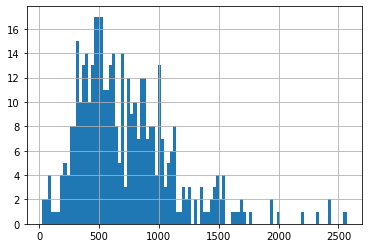

In [ ]:
new_train['총세대수'].hist(bins=100)

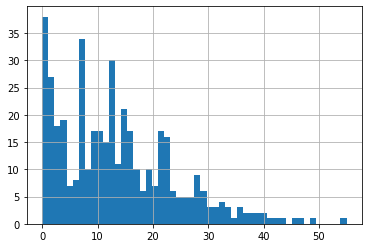

In [ ]:
new_train['공가수'].hist(bins=50)

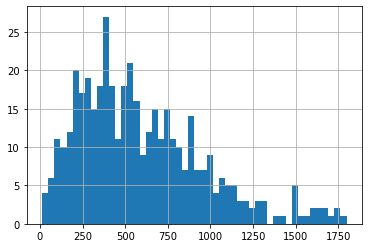

In [ ]:
new_train['단지내주차면수'].hist(bins=50)

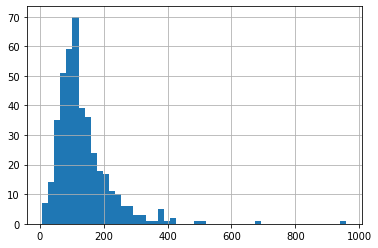

In [ ]:
new_train['전용면적별세대수'].hist(bins=50)

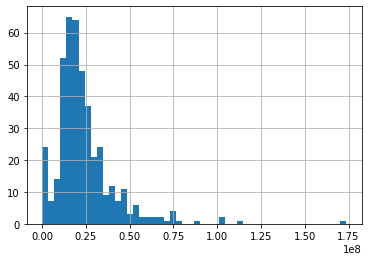

In [ ]:
new_train['임대보증금'].hist(bins=50)

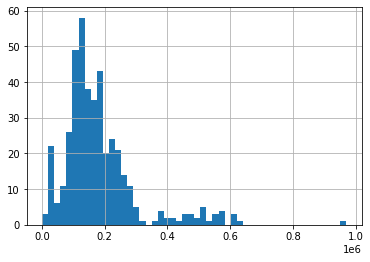

In [ ]:
new_train['임대료'].hist(bins=50)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

new_train['총세대수']=sc.fit_transform(new_train.loc[:,new_train.columns=='총세대수'])
new_test['총세대수']=sc.transform(new_test.loc[:,new_test.columns=='총세대수'])

new_train['공가수']=sc.fit_transform(new_train.loc[:,new_train.columns=='공가수'])
new_test['공가수']=sc.transform(new_test.loc[:,new_test.columns=='공가수'])

new_train['단지내주차면수']=sc.fit_transform(new_train.loc[:,new_train.columns=='단지내주차면수'])
new_test['단지내주차면수']=sc.transform(new_test.loc[:,new_test.columns=='단지내주차면수'])

new_train['전용면적별세대수']=sc.fit_transform(new_train.loc[:,new_train.columns=='전용면적별세대수'])
new_test['전용면적별세대수']=sc.transform(new_test.loc[:,new_test.columns=='전용면적별세대수'])

new_train['임대보증금']=sc.fit_transform(new_train.loc[:,new_train.columns=='임대보증금'])
new_test['임대보증금']=sc.transform(new_test.loc[:,new_test.columns=='임대보증금'])

new_train['임대료']=sc.fit_transform(new_train.loc[:,new_train.columns=='임대료'])
new_test['임대료']=sc.transform(new_test.loc[:,new_test.columns=='임대료'])

In [ ]:
new_train.head(3)

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료,등록차량수
0,C2483,0.438429,2.363808,경상북도,2.266365,0.0,3.0,-0.258160,0.038903,-0.118147,1015.0
1,C2515,-0.437875,0.339347,경상남도,0.085113,0.0,3.0,-0.641426,-0.421715,-0.350864,205.0
2,C1407,1.218463,-0.046264,대전광역시,1.885123,1.0,1.0,-0.238799,0.108550,-0.134183,1064.0


# age_gender_info

In [ ]:
age_gender.head(3)

,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
지역,,,,,,,,,,,,,,,,,,,,,,
경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,0.085751,0.068819,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066


## 퍼센트 임을 확인

In [ ]:
row=age_gender.iloc[2,:]
print(row)
total=0
for i in range(0,len(row)):
    total=total+row[i]
print(total)

10대미만(여자)    0.028197
10대미만(남자)    0.029092
10대(여자)      0.040490
10대(남자)      0.042793
20대(여자)      0.060834
20대(남자)      0.064247
30대(여자)      0.068654
30대(남자)      0.066848
40대(여자)      0.074667
40대(남자)      0.067925
50대(여자)      0.085751
50대(남자)      0.068819
60대(여자)      0.088468
60대(남자)      0.070261
70대(여자)      0.051010
70대(남자)      0.037143
80대(여자)      0.032455
80대(남자)      0.013751
90대(여자)      0.006494
90대(남자)      0.001740
100대(여자)     0.000298
100대(남자)     0.000066
Name: 대전광역시, dtype: float64
1.0000000000000002


각 숫자가 의미하는 바가 전체에서 비율(백분율)일 것 같아서 행 하나를 더해보았더니 1이 나오므로 비율을 의미하는 것이 맞다

## 상위 세 그룹 열 추가

여자:0<br>
남자:1

In [ ]:
#열 이름 변경
age_columns=[]
for i in range(0,11):
    for j in range(0,2):
        temp=str(i)+"_"+str(j)
        age_columns.append(temp)

print(len(age_columns))
print(age_columns)

age_gender.columns = age_columns

22
['0_0', '0_1', '1_0', '1_1', '2_0', '2_1', '3_0', '3_1', '4_0', '4_1', '5_0', '5_1', '6_0', '6_1', '7_0', '7_1', '8_0', '8_1', '9_0', '9_1', '10_0', '10_1']


In [ ]:
#열 추가
age_gender['1st']=0
age_gender['1gender']=0
age_gender['2nd']=0
age_gender['2gender']=0
age_gender['3rd']=0
age_gender['3gender']=0

In [ ]:
for id in age_gender.index:
    temp=pd.DataFrame(age_gender.loc[id]).T
    temp=temp.sort_values(axis=1,by=[id],ascending=False)
    temp_ascend=temp.columns
    
    age_gender['1st'].loc[id]=temp_ascend[0].split('_')[0]
    age_gender['1gender'].loc[id]=temp_ascend[0].split('_')[1]
    age_gender['2nd'].loc[id]=temp_ascend[1].split('_')[0]
    age_gender['2gender'].loc[id]=temp_ascend[1].split('_')[1]
    age_gender['3rd'].loc[id]=temp_ascend[2].split('_')[0]
    age_gender['3gender'].loc[id]=temp_ascend[2].split('_')[1]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
age_gender.head(4)

,0_0,0_1,1_0,1_1,2_0,2_1,3_0,3_1,4_0,4_1,5_0,5_1,6_0,6_1,7_0,7_1,8_0,8_1,9_0,9_1,10_0,10_1,1st,1gender,2nd,2gender,3rd,3gender
지역,,,,,,,,,,,,,,,,,,,,,,,,,,,,
경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,5,0,4,0,6,0
경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010,6,0,5,0,4,0
대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,0.085751,0.068819,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066,6,0,5,0,4,0
경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067,4,0,4,1,5,0


In [ ]:
age_gender=age_gender.drop(columns=age_columns,axis=1)
age_gender.head(2)

,1st,1gender,2nd,2gender,3rd,3gender
지역,,,,,,
경상북도,5,0,4,0,6,0
경상남도,6,0,5,0,4,0


In [ ]:
# age_gender.to_csv("age_gender_가공됨.csv")

##age_gender과 train 병합

In [ ]:
#열 추가
new_train['1st']=0
new_train['1gender']=0
new_train['2nd']=0
new_train['2gender']=0
new_train['3rd']=0
new_train['3gender']=0

new_test['1st']=0
new_test['1gender']=0
new_test['2nd']=0
new_test['2gender']=0
new_test['3rd']=0
new_test['3gender']=0

In [ ]:
new_train.head(3)

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료,등록차량수,1st,1gender,2nd,2gender,3rd,3gender
0,C2483,0.438429,2.363808,경상북도,2.266365,0.0,3.0,-0.258160,0.038903,-0.118147,1015.0,0,0,0,0,0,0
1,C2515,-0.437875,0.339347,경상남도,0.085113,0.0,3.0,-0.641426,-0.421715,-0.350864,205.0,0,0,0,0,0,0
2,C1407,1.218463,-0.046264,대전광역시,1.885123,1.0,1.0,-0.238799,0.108550,-0.134183,1064.0,0,0,0,0,0,0


In [ ]:
new_test.head(3)

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료,1st,1gender,2nd,2gender,3rd,3gender
0,C1072,0.078034,0.050139,경기도,0.245780,0.0,2.0,-0.460066,0.808241,0.685683,0,0,0,0,0,0
1,C1128,1.559111,-0.431876,경기도,1.697225,0.0,3.0,0.161632,0.577896,0.518840,0,0,0,0,0,0
2,C1456,-0.255209,0.435750,부산광역시,-0.124570,0.0,16.0,-0.765691,0.553674,0.328198,0,0,0,0,0,0


In [ ]:
print(new_train['1st'].iloc[0])
print(age_gender['1st'].loc['경상북도'])

0
5


In [ ]:
#train
for i in range(len(new_train)):
    temp = new_train['지역'].loc[i]
    for row in age_gender.index:
        if temp==row:
            new_train['1st'].iloc[i]=age_gender['1st'].loc[row]
            new_train['1gender'].iloc[i]=age_gender['1gender'].loc[row]
            new_train['2nd'].iloc[i]=age_gender['2nd'].loc[row]
            new_train['2gender'].iloc[i]=age_gender['2gender'].loc[row]
            new_train['3rd'].iloc[i]=age_gender['3rd'].loc[row]
            new_train['3gender'].iloc[i]=age_gender['3gender'].loc[row]

#test
for i in range(len(new_test)):
    temp = new_test['지역'].loc[i]
    for row in age_gender.index:
        if temp==row:
            new_test['1st'].iloc[i]=age_gender['1st'].loc[row]
            new_test['1gender'].iloc[i]=age_gender['1gender'].loc[row]
            new_test['2nd'].iloc[i]=age_gender['2nd'].loc[row]
            new_test['2gender'].iloc[i]=age_gender['2gender'].loc[row]
            new_test['3rd'].iloc[i]=age_gender['3rd'].loc[row]
            new_test['3gender'].iloc[i]=age_gender['3gender'].loc[row]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
new_train.tail(3)

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료,등록차량수,1st,1gender,2nd,2gender,3rd,3gender
420,C2020,-1.684448,-0.624682,부산광역시,-1.546060,1.0,2.0,-1.355276,0.232448,-0.380252,19.0,6,0,6,1,5,0
421,C2437,-1.561025,-0.142667,충청북도,-1.532444,0.0,1.0,-0.507086,-0.793077,-0.613740,16.0,5,0,4,0,6,0
422,C2532,-1.193224,-0.624682,강원도,-1.162094,0.0,1.0,-0.988341,-0.608553,-0.364179,146.0,6,0,5,0,4,0


In [ ]:
new_test.tail(3)

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료,1st,1gender,2nd,2gender,3rd,3gender
147,C2152,-1.486971,-0.431876,0,-1.505213,0.0,1.0,-0.838986,-1.389574,-1.496334,6,0,5,0,4,0
148,C1267,-0.116975,2.363808,2,-0.342423,0.0,1.0,-0.828928,-0.911364,-0.802372,6,0,5,0,4,0
149,C2189,-0.840234,3.038629,12,-0.797191,0.0,2.0,-0.457301,-0.728807,-0.421305,5,0,4,0,6,0


###지역 열만 다시 label encoder

In [ ]:
le.fit(new_train.loc[:,new_train.columns=='지역'])
new_train['지역']=le.transform(new_train.loc[:,new_train.columns=='지역'])
new_test['지역']=le.transform(new_test.loc[:,new_test.columns=='지역'])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
for col in ['1st', '1gender', '2nd', '2gender', '3rd', '3gender']:
    new_train[col]=new_train[col].astype(np.int16)
    new_test[col]=new_test[col].astype(np.int16)

In [ ]:
new_train.tail()

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료,등록차량수,1st,1gender,2nd,2gender,3rd,3gender
418,C2586,-1.561025,-0.624682,13,-1.434411,0.0,3.0,-1.303647,0.118676,-0.583781,57.0,5,0,4,0,6,0
419,C2035,-0.568703,1.014168,0,-0.195372,0.0,1.0,-0.414154,-0.482664,-0.192921,246.0,6,0,5,0,4,0
420,C2020,-1.684448,-0.624682,7,-1.546060,1.0,2.0,-1.355276,0.232448,-0.380252,19.0,6,0,6,1,5,0
421,C2437,-1.561025,-0.142667,15,-1.532444,0.0,1.0,-0.507086,-0.793077,-0.613740,16.0,5,0,4,0,6,0
422,C2532,-1.193224,-0.624682,0,-1.162094,0.0,1.0,-0.988341,-0.608553,-0.364179,146.0,6,0,5,0,4,0


In [ ]:
new_test.tail()

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료,1st,1gender,2nd,2gender,3rd,3gender
145,C2456,-0.921693,0.339347,13,-0.878886,0.0,4.0,-0.545807,-0.684528,-0.223434,5,0,4,0,6,0
146,C1266,-0.311983,2.074600,15,0.000695,0.0,1.0,-0.195099,-0.561928,0.144243,5,0,4,0,6,0
147,C2152,-1.486971,-0.431876,0,-1.505213,0.0,1.0,-0.838986,-1.389574,-1.496334,6,0,5,0,4,0
148,C1267,-0.116975,2.363808,2,-0.342423,0.0,1.0,-0.828928,-0.911364,-0.802372,6,0,5,0,4,0
149,C2189,-0.840234,3.038629,12,-0.797191,0.0,2.0,-0.457301,-0.728807,-0.421305,5,0,4,0,6,0


In [ ]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423 entries, 0 to 422
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      423 non-null    object 
 1   총세대수      423 non-null    float64
 2   공가수       423 non-null    float64
 3   지역        423 non-null    int64  
 4   단지내주차면수   423 non-null    float64
 5   지하철       423 non-null    float64
 6   버스        423 non-null    float64
 7   전용면적별세대수  423 non-null    float64
 8   임대보증금     423 non-null    float64
 9   임대료       423 non-null    float64
 10  등록차량수     423 non-null    float64
 11  1st       423 non-null    int16  
 12  1gender   423 non-null    int16  
 13  2nd       423 non-null    int16  
 14  2gender   423 non-null    int16  
 15  3rd       423 non-null    int16  
 16  3gender   423 non-null    int16  
dtypes: float64(9), int16(6), int64(1), object(1)
memory usage: 64.6+ KB


In [ ]:
new_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      150 non-null    object 
 1   총세대수      150 non-null    float64
 2   공가수       150 non-null    float64
 3   지역        150 non-null    int64  
 4   단지내주차면수   150 non-null    float64
 5   지하철       150 non-null    float64
 6   버스        150 non-null    float64
 7   전용면적별세대수  150 non-null    float64
 8   임대보증금     150 non-null    float64
 9   임대료       150 non-null    float64
 10  1st       150 non-null    int16  
 11  1gender   150 non-null    int16  
 12  2nd       150 non-null    int16  
 13  2gender   150 non-null    int16  
 14  3rd       150 non-null    int16  
 15  3gender   150 non-null    int16  
dtypes: float64(8), int16(6), int64(1), object(1)
memory usage: 19.6+ KB


#Model

In [ ]:
new_train.head()

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료,등록차량수,1st,1gender,2nd,2gender,3rd,3gender
0,C2483,0.438429,2.363808,3,2.266365,0.0,3.0,-0.258160,0.038903,-0.118147,1015.0,5,0,4,0,6,0
1,C2515,-0.437875,0.339347,2,0.085113,0.0,3.0,-0.641426,-0.421715,-0.350864,205.0,6,0,5,0,4,0
2,C1407,1.218463,-0.046264,6,1.885123,1.0,1.0,-0.238799,0.108550,-0.134183,1064.0,6,0,5,0,4,0
3,C1945,0.080502,-0.721085,1,0.384661,1.0,3.0,-0.097742,-0.002365,0.152746,730.0,4,0,4,1,5,0
4,C1470,-0.065137,0.050139,12,0.142300,0.0,2.0,0.422236,-0.367772,-0.510156,553.0,5,0,4,0,6,0


In [ ]:
new_train.columns

Index(['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스', '전용면적별세대수',
       '임대보증금', '임대료', '등록차량수', '1st', '1gender', '2nd', '2gender', '3rd',
       '3gender'],
      dtype='object')

In [ ]:
new_train = new_train[['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스', '전용면적별세대수',
       '임대보증금', '임대료', '1st', '1gender', '2nd', '2gender', '3rd',
       '3gender', '등록차량수']]

In [ ]:
new_train.head(3)

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료,1st,1gender,2nd,2gender,3rd,3gender,등록차량수
0,C2483,0.438429,2.363808,3,2.266365,0.0,3.0,-0.258160,0.038903,-0.118147,5,0,4,0,6,0,1015.0
1,C2515,-0.437875,0.339347,2,0.085113,0.0,3.0,-0.641426,-0.421715,-0.350864,6,0,5,0,4,0,205.0
2,C1407,1.218463,-0.046264,6,1.885123,1.0,1.0,-0.238799,0.108550,-0.134183,6,0,5,0,4,0,1064.0


In [ ]:
new_test.head(3)

,단지코드,총세대수,공가수,지역,단지내주차면수,지하철,버스,전용면적별세대수,임대보증금,임대료,1st,1gender,2nd,2gender,3rd,3gender
0,C1072,0.078034,0.050139,1,0.245780,0.0,2.0,-0.460066,0.808241,0.685683,4,0,4,1,5,0
1,C1128,1.559111,-0.431876,1,1.697225,0.0,3.0,0.161632,0.577896,0.518840,4,0,4,1,5,0
2,C1456,-0.255209,0.435750,7,-0.124570,0.0,16.0,-0.765691,0.553674,0.328198,6,0,6,1,5,0


In [ ]:
x_train_all = new_train.iloc[:, 1:-1]
y_train_all = new_train.iloc[:,-1]
x_test = new_test.iloc[:,1:]

## train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, test_size=0.15, random_state=42)

##Baseline

In [ ]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
print(model.score(x_train,y_train))
print(model.score(x_valid,y_valid))

0.9644366559915947
0.6870003405529015


In [ ]:
#age_gender_info 포함(나이대 10으로 안 나눔) /평균 random forest drop_duplicate
0.9597890507858122
0.7704457732232735

#age_gender_info 포함(나이대 10으로 나눔) /평균 random forest drop_duplicate
0.9649168569732572
0.6784872771951496

#age_gender_info 포함(나이대 10으로 나눔) 평균 전에 합침/평균 random forest drop_duplicate/standardscaler
0.9649895369472162
0.6798802467335323

# age_gender_info 포함(나이대 10으로 나눔)평균 후에 합침/평균 random forest drop_duplicate/standardscaler
0.9644366559915947
0.6870003405529015

0.6798802467335323

In [ ]:
pred = model.predict(x_test)
submission['num'] = pred
submission.to_csv('standardscaler&age평균후.csv', index=False)